In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housing-prices-competition-for-kaggle-learn-users/train.csv
/kaggle/input/housing-prices-competition-for-kaggle-learn-users/test.csv


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv('../input/housing-prices-competition-for-kaggle-learn-users/train.csv', index_col='Id') 
X_test = pd.read_csv('../input/housing-prices-competition-for-kaggle-learn-users/test.csv', index_col='Id')

print(X.shape)
print(X_test.shape)

#Q1: Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
print(X.shape)

#Q2: Separate target from predictors (i.e. input features)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

(1460, 80)
(1459, 79)
(1460, 80)


In [30]:
#Q3: Perform ordinal encoding to categorical feature columns 
from sklearn.preprocessing import OrdinalEncoder

# Get the columns that contain strings and treat them as categorical
object_cols = [col for col in X.columns if X[col].dtype == "object"]

# Columns that can be safely ordinal encoded
good_label_cols = [col for col in object_cols if 
                   set(X_test[col]).issubset(set(X[col]))]
        
# Problematic columns that will be dropped from the dataset
bad_label_cols = list(set(object_cols)-set(good_label_cols))

print('Categorical columns that will be ordinal encoded:', good_label_cols)
print('\nCategorical columns that will be dropped from the dataset:', bad_label_cols)

# Drop categorical columns that will not be encoded
X_train_ordinal = X.drop(bad_label_cols, axis=1)
X_test_ordinal = X_test.drop(bad_label_cols, axis=1)

# Apply ordinal encoder 
ordinal_encoder = OrdinalEncoder() # Your code here
X_train_ordinal[good_label_cols] = ordinal_encoder.fit_transform(X_train_ordinal[good_label_cols])
X_test_ordinal[good_label_cols] = ordinal_encoder.transform(X_test_ordinal[good_label_cols])

Categorical columns that will be ordinal encoded: ['Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleCondition']

Categorical columns that will be dropped from the dataset: ['SaleType', 'KitchenQual', 'Functional', 'Exterior1st', 'Utilities', 'Exterior2nd', 'MSZoning']


In [31]:
#Q4: fill missing values in train and test sets using SimpleImputer
from sklearn.impute import SimpleImputer

final_imputer = SimpleImputer(strategy='median')

X_train_imputed = final_imputer.fit_transform(X_train_ordinal)
X_test_imputed = pd.DataFrame(final_imputer.transform(X_test_ordinal))
X_test_imputed.columns = X_test_ordinal.columns

In [32]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=0)
model.fit(X_train_imputed, y)
preds_test = model.predict(X_test_imputed)

#Q6: Store the predictions as a pandas dataframe for submission
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

Submission Score: 14664.82491 Submission Place: 759

In [33]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

itrtv_imputer = IterativeImputer(max_iter =10)

X_train_itrtv_imputed = itrtv_imputer.fit_transform(X_train_ordinal)
X_test_itrtv_imputed = pd.DataFrame(itrtv_imputer.transform(X_test_ordinal))
X_test_itrtv_imputed.columns = X_test_ordinal.columns

In [34]:

model.fit(X_train_itrtv_imputed, y)
preds_test = model.predict(X_test_itrtv_imputed)

#Q6: Store the predictions as a pandas dataframe for submission
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission_itrtv.csv', index=False)

Submission Score: 14611.77751
Submission Place: 717

In [35]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors =3)

X_train_knn_imputed = knn_imputer.fit_transform(X_train_ordinal)
X_test_knn_imputed = pd.DataFrame(knn_imputer.transform(X_test_ordinal))
X_test_knn_imputed.columns = X_test_ordinal.columns

In [36]:
model.fit(X_train_knn_imputed, y)
preds_test = model.predict(X_test_knn_imputed)

#Q6: Store the predictions as a pandas dataframe for submission
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission_knn.csv', index=False)

Submission Score: 14826.62424

In [37]:
from sklearn.model_selection import cross_val_score


def score_dataset(trainset):
   
    final_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, random_state=0)
    scores = -1 * cross_val_score(final_model, trainset, y,
                              cv=3,
                              scoring='neg_mean_absolute_error')
    return scores.mean()

Max iteration: 1 MAE: 16587.61759125355
Max iteration: 3 MAE: 16587.61759125355
Max iteration: 5 MAE: 16587.61759125355
Max iteration: 7 MAE: 16587.61759125355
Max iteration: 9 MAE: 16587.61759125355
Max iteration: 11 MAE: 16587.61759125355


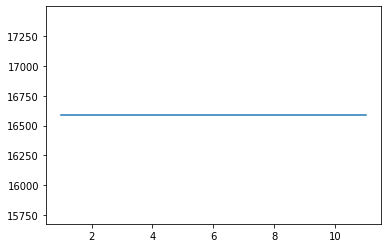

In [41]:
import matplotlib.pyplot as plt
iterativeList ={}
for i in range(1,7):
    imputer = IterativeImputer(max_iter=i*2-1)
    X_itrtv_imputed = imputer.fit_transform(X_train_ordinal)
    mae = score_dataset(X_itrtv_imputed)
    iterativeList[i*2-1] = mae
    print('Max iteration:', i*2-1,'MAE:',mae)

iteration = list(iterativeList.keys())
mae = list(iterativeList.values())

plt.plot(iteration, mae)
plt.show()

All of the iteration number gave the same result.

Max iteration: 1 MAE: 16587.61759125355
Max iteration: 3 MAE: 16587.61759125355
Max iteration: 5 MAE: 16587.61759125355
Max iteration: 7 MAE: 16587.61759125355
Max iteration: 9 MAE: 16587.61759125355

Neighbours: 1 MAE: 16244.136252021877
Neighbours: 3 MAE: 16265.531355753492
Neighbours: 5 MAE: 16335.60195179036
Neighbours: 7 MAE: 16210.944985419519
Neighbours: 9 MAE: 16377.66587003584
Neighbours: 11 MAE: 16396.106060244467


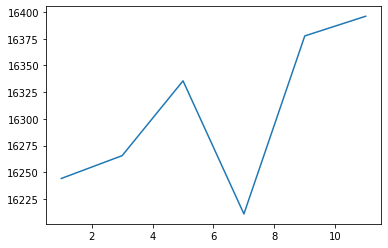

In [44]:
knnList ={}
for i in range(1,7):
    imputer = KNNImputer(n_neighbors =i*2-1)
    X_knn_imputed = imputer.fit_transform(X_train_ordinal)
    mae = score_dataset(X_knn_imputed)
    knnList[i*2-1] = mae
    print('Neighbours:', i*2-1,'MAE:',mae)

n = list(knnList.keys())
mae = list(knnList.values())

plt.plot(n, mae)
plt.show()

The best score was for n_neighbors = 7

In [47]:
final_iterative = IterativeImputer(max_iter =9)

X_train_itrtv_imputed = final_iterative.fit_transform(X_train_ordinal)
X_test_itrtv_imputed = pd.DataFrame(final_iterative.transform(X_test_ordinal))
X_test_itrtv_imputed.columns = X_test_ordinal.columns

model.fit(X_train_itrtv_imputed, y)
preds_test = model.predict(X_test_itrtv_imputed)


output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission_itrtv_final_1.csv', index=False)

Score: 14611.77751 with iterative imputer max_iter = 9

In [48]:
final_knn = KNNImputer(n_neighbors =7)

X_train_knn_imputed = final_knn.fit_transform(X_train_ordinal)
X_test_knn_imputed = pd.DataFrame(final_knn.transform(X_test_ordinal))
X_test_knn_imputed.columns = X_test_ordinal.columns

model.fit(X_train_knn_imputed, y)
preds_test = model.predict(X_test_knn_imputed)


output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission_knn_final.csv', index=False)

Score  14734.29326 with knn imputer m_neighbors = 7